# import packages

In [1]:
import numpy as np
import pandas as pd


## utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix,root_mean_squared_error
from sklearn import preprocessing

from tqdm import tqdm


# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib.patches import Rectangle

### Logistic and Linear Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


## Random forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

### xgboost
import xgboost as xgb
from xgboost import XGBRegressor



folder = "G:\\Drive condivisi\\Nota metodologica ML for panel data\\results_ml_replication\\"

## Some utils

In [2]:
## Set Seed
random_seed=14052024

## Dictionary for label names
dict_nomi = dict(pd.read_excel(f"{folder}\\data\\variable_description.xlsx")[["nome_var","name clean"]].values)
dict_nomi["leaked_space"]="Spat. Leak"

## Color Palette
pal = sns.color_palette("cubehelix",6).as_hex()


## Create a function to evaluate predictions

In [3]:
def evaluate_predictions(y_true, y_pred_prob):
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Determine the best threshold
    best_threshold_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_threshold_idx]
    
    # Make predictions based on the best threshold
    y_pred = (y_pred_prob > best_threshold).astype(int)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Create the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate sensitivity and specificity
    sens = tp / (tp + fn)  # True Positive Rate
    spec = tn / (tn + fp)  # True Negative Rate
    
    return fpr, tpr, y_pred, conf_matrix,roc_auc,best_threshold,sens,spec

## load data

## Rearrange the Dataset 

In [4]:
df = pd.read_stata(f"{folder}data\\US_counties_dataset_2000-2019_ready_for_analysis.dta") ## load the data
df.drop(['perc_votes_rep_', 'perc_votes_dem_', 'perc_votes_others_', 'turnout'],axis=1,inplace=True) ### drop variables we do not use
df =  df.loc[:,[
        'ibrc_geo_id', 'year', 'statefips', 'countyfips', 'county_name', ## ids
        'pop_','perc_pop_under18_', 'perc_pop_65plus_', 'perc_women_', ## demographics 1 
       'perc_white_', 'perc_black_', 'perc_hispanic_', 'perc_asian_american_', ## demographichs 2
       'births_per_1000ab', 'deaths_per_1000ab', ## demographic 3
       'avg_wage_salaries_', 'perc_income_from_unempl_ins_','raw_employment_rate',  ## labour market
       #'perc_votes_rep_', 'perc_votes_dem_', 'perc_votes_others_', 'turnout', ### political
       'saldo_intern_migrants_per_1000ab', 'saldo_domest_migrants_per_1000ab', ##  migration
       'log_income_pc','income_pc_',"growth_pc","degrowth" ## income
       ]] ## select and order only relavant variables

## Create Lagged variables and define group of covariates

In [5]:
var_to_lag = ['pop_','perc_pop_under18_', 'perc_pop_65plus_', 'perc_women_', ## demographics 1 
       'perc_white_', 'perc_black_', 'perc_hispanic_', 'perc_asian_american_', ## demographichs 2
       'births_per_1000ab', 'deaths_per_1000ab', ## demographic 3
       'avg_wage_salaries_', 'perc_income_from_unempl_ins_','raw_employment_rate',  ## labour market
       #'perc_votes_rep_', 'perc_votes_dem_', 'perc_votes_others_', 'turnout', ### political
       'saldo_intern_migrants_per_1000ab', 'saldo_domest_migrants_per_1000ab', ##  migration
       'log_income_pc','income_pc_',"growth_pc","degrowth" ## income
       ]
not_to_lag = ['ibrc_geo_id', 'year', 'statefips', 'countyfips', 'county_name']  ## We do not lag variables that do not change over years

size_lag = 1
for size_lag in range(1,3):
    df_lag = df.loc[:,var_to_lag+not_to_lag].copy()
    df_lag.loc[:,"year"] = df_lag["year"]+1
    df_lag.columns = [x+f"_lag_{size_lag}"  if x not in not_to_lag else x for x in df_lag.columns]
    df = pd.merge(df,df_lag,how="left",on=not_to_lag)

x_covariates = ['pop_','perc_pop_under18_', 'perc_pop_65plus_', 'perc_women_', ## demographics 1 
       'perc_white_', 'perc_black_', 'perc_hispanic_', 'perc_asian_american_', ## demographichs 2
       'births_per_1000ab', 'deaths_per_1000ab', ## demographic 3
       'avg_wage_salaries_', 'perc_income_from_unempl_ins_','raw_employment_rate',  ## labour market
       #'perc_votes_rep_', 'perc_votes_dem_', 'perc_votes_others_', 'turnout', ### political
       'saldo_intern_migrants_per_1000ab', 'saldo_domest_migrants_per_1000ab', ##  migration
    ]
x_covariates_with_lag = df.columns[df.columns.str.contains("|".join(x_covariates))]
lag_dependent = df.columns[(df.columns.str.contains("|".join(x_covariates))==False)&(df.columns.str.contains("lag"))]

## Function to create Samples Splits

In [6]:
indici_2009 = df.loc[df["year"]==2009].index ## creat a list of the indexes of observation of the recession year
def create_sample(period = "all",dep_var = "degrowth"):
    '''
    This function create five different train_test splits (random, time, space, space_states and space time).
    The only thing that vary is the period (all periods or recession) and the dependent variable 
    period = "all","recession" 
    '''
    ## create a copy of the original dataset
    dr=df.copy()
    ## clean NA (that arises because of lags)
    dr = dr.loc[:,list(x_covariates_with_lag)+list(lag_dependent)+not_to_lag+[dep_var]].dropna()
    
    if period == "all":
        ## Random Splits
        # (Simply a Random Split)
        ## set X and Y
        X = dr.loc[:,list(x_covariates_with_lag)+list(lag_dependent)+not_to_lag]
        y = dr.loc[:,[dep_var]]

        X_train, X_test, y_train, y_test = train_test_split(X.drop(not_to_lag,axis=1), y, test_size=0.22, random_state=random_seed)

        ## Time Splits
        # (Define the years of testing and train)
        year_training = [2002,2015] 
        year_testing=[2016,2019]

        # (Sample with train years)
        training = dr.loc[dr["year"].isin(range(year_training[0],year_training[1]+1))].copy()

        # (Sample with test years)
        testing = dr.loc[dr["year"].isin(range(year_testing[0],year_testing[1]+1))].copy()

        X_train_time, y_train_time = training.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], training.loc[:,[dep_var]]
        X_test_time, y_test_time  = testing.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], testing.loc[:,[dep_var]]

        ## Space Split

        ## Randomly select train and test counties
        train_counties = pd.Series(dr["ibrc_geo_id"].unique()).sample(frac=0.8,random_state=random_seed).to_list() ## train counties
        test_counties = [x for x in dr["ibrc_geo_id"].unique() if x not in train_counties] ## test counties
        
        ## (Sample with Train Counties)
        training = dr.loc[dr["ibrc_geo_id"].isin(train_counties)].copy()
        ## (Sample with Test Counties)
        testing = dr.loc[dr["ibrc_geo_id"].isin(test_counties)].copy()

        X_train_space, y_train_space = training.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], training.loc[:,[dep_var]]
        X_test_space, y_test_space  = testing.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], testing.loc[:,[dep_var]]
        

        ## Space State Split

        ## Randomly select train and test states
        train_states = pd.Series(dr["statefips"].unique()).sample(frac=0.8,random_state=random_seed).to_list() ## train states
        test_states =  [x for x in dr["statefips"].unique() if x not in train_states] ## test states

        training = dr.loc[dr["statefips"].isin(train_states)].copy()
        testing = dr.loc[dr["statefips"].isin(test_states)].copy()

        X_train_space_states, y_train_space_states = training.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], training.loc[:,[dep_var]]
        X_test_space_states, y_test_space_states  = testing.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], testing.loc[:,[dep_var]]

        ## Time and Space Split
        ## Randomly select train and test counties
        train_counties = pd.Series(dr["ibrc_geo_id"].unique()).sample(frac=0.8,random_state=random_seed).to_list() ## train counties
        test_counties = [x for x in dr["ibrc_geo_id"].unique() if x not in train_counties] ## test counties

        ## now filter by years
        training = dr.loc[(dr["ibrc_geo_id"].isin(train_counties))&(dr["year"].isin(range(year_training[0],year_training[1]+1)))].copy()
        testing = dr.loc[(dr["ibrc_geo_id"].isin(test_counties))&(dr["year"].isin(range(year_testing[0],year_testing[1]+1)))].copy()

        X_train_space_time, y_train_space_time = training.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], training.loc[:,[dep_var]]
        X_test_space_time, y_test_space_time  = testing.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], testing.loc[:,[dep_var]]


        ## create dictionary with all samples
        dic_samples = dict({"random":{"train":{"x":X_train,"y":y_train},"test":{"x":X_test,"y":y_test}},
            "time":{"train":{"x":X_train_time,"y":y_train_time},"test":{"x":X_test_time,"y":y_test_time}},
            "space":{"train":{"x":X_train_space,"y":y_train_space},"test":{"x":X_test_space,"y":y_test_space}},
            "space_states":{"train":{"x":X_train_space_states,"y":y_train_space_states},"test":{"x":X_test_space_states,"y":y_test_space_states}},
            "space_time":{"train":{"x":X_train_space_time,"y":y_train_space_time},"test":{"x":X_test_space_time,"y":y_test_space_time}}
         })
        
        ## now for each sample
        nomi_samples =dic_samples.keys()
        list_train_x = []
        list_test_x = []

        ## get the size of train and test
        for nome_sample in nomi_samples:
            list_train_x.append(dic_samples[nome_sample]["train"]["x"])
            list_test_x.append(dic_samples[nome_sample]["test"]["x"])
        
        ## get the minimum size of train and test
        min_train = min([x.shape[0] for x in list_train_x])
        min_test = min([x.shape[0] for x in list_test_x])

        for nome_sample in nomi_samples:
            
            ## Adjust Train
            ## adjust dimensions of the x
            dic_samples[nome_sample]["train"]["x_adj"] = dic_samples[nome_sample]["train"]["x"].sample(n=min_train,random_state=random_seed)
            ## adjust dimensions of the y
            dic_samples[nome_sample]["train"]["y_adj"] = dic_samples[nome_sample]["train"]["y"].loc[dic_samples[nome_sample]["train"]["x_adj"].index]

            ## Adjust Test
            ## adjust dimensions of the x
            dic_samples[nome_sample]["test"]["x_adj"] = dic_samples[nome_sample]["test"]["x"].sample(n=min_test,random_state=random_seed)
            ## adjust dimensions of the y
            dic_samples[nome_sample]["test"]["y_adj"] = dic_samples[nome_sample]["test"]["y"].loc[dic_samples[nome_sample]["test"]["x_adj"].index]
        

        return dic_samples
    

    ## the rest of the code is exactly the same, with the only difference that the test set is restricted to 2009 observations
    elif period == "recession":
        ## Random Splits
        ## set X and Y
        X = dr.loc[(dr["year"]>=2003)&(dr["year"]<=2009),list(x_covariates_with_lag)+list(lag_dependent)+not_to_lag]
        y = dr.loc[(dr["year"]>=2003)&(dr["year"]<=2009),[dep_var]]

        X_train, X_test, y_train, y_test = train_test_split(X.drop(not_to_lag,axis=1), y, test_size=0.22, random_state=random_seed)

        ## Time Splits
        ### filter window
        year_training = [2003,2008] 
        year_testing=[2009,2009]

        training = dr.loc[dr["year"].isin(range(year_training[0],year_training[1]+1))].copy()

        testing = dr.loc[dr["year"].isin(range(year_testing[0],year_testing[1]+1))].copy()

        X_train_time, y_train_time = training.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], training.loc[:,[dep_var]]
        X_test_time, y_test_time  = testing.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], testing.loc[:,[dep_var]]

        ## space

        train_counties = pd.Series(dr["ibrc_geo_id"].unique()).sample(frac=0.8,random_state=random_seed).to_list()
        test_counties = [x for x in dr["ibrc_geo_id"].unique() if x not in train_counties]

        training = dr.loc[dr["ibrc_geo_id"].isin(train_counties)].copy()
        testing = dr.loc[dr["ibrc_geo_id"].isin(test_counties)].copy()

        X_train_space, y_train_space = training.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], training.loc[:,[dep_var]]
        X_test_space, y_test_space  = testing.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], testing.loc[:,[dep_var]]

        ## space states
        train_states = pd.Series(dr["statefips"].unique()).sample(frac=0.8,random_state=random_seed).to_list()
        test_states =  [x for x in dr["statefips"].unique() if x not in train_states]

        training = dr.loc[dr["statefips"].isin(train_states)].copy()
        testing = dr.loc[dr["statefips"].isin(test_states)].copy()

        X_train_space_states, y_train_space_states = training.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], training.loc[:,[dep_var]]
        X_test_space_states, y_test_space_states  = testing.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], testing.loc[:,[dep_var]]

        ## time and space
        train_counties = pd.Series(dr["ibrc_geo_id"].unique()).sample(frac=0.8,random_state=random_seed).to_list()
        test_counties = [x for x in dr["ibrc_geo_id"].unique() if x not in train_counties]

        training = dr.loc[(dr["ibrc_geo_id"].isin(train_counties))&(dr["year"].isin(range(year_training[0],year_training[1]+1)))].copy()
        testing = dr.loc[(dr["ibrc_geo_id"].isin(test_counties))&(dr["year"].isin(range(year_testing[0],year_testing[1]+1)))].copy()

        X_train_space_time, y_train_space_time = training.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], training.loc[:,[dep_var]]
        X_test_space_time, y_test_space_time  = testing.loc[:,list(x_covariates_with_lag)+list(lag_dependent)], testing.loc[:,[dep_var]]




        dic_samples = dict({"random":{"train":{"x":X_train,"y":y_train},"test":{"x":X_test,"y":y_test}},
                        "time":{"train":{"x":X_train_time,"y":y_train_time},"test":{"x":X_test_time,"y":y_test_time}},
                        "space":{"train":{"x":X_train_space,"y":y_train_space},"test":{"x":X_test_space,"y":y_test_space}},
                        "space_states":{"train":{"x":X_train_space_states,"y":y_train_space_states},"test":{"x":X_test_space_states,"y":y_test_space_states}},
                        "space_time":{"train":{"x":X_train_space_time,"y":y_train_space_time},"test":{"x":X_test_space_time,"y":y_test_space_time}}
                        })
        
        nomi_samples =dic_samples.keys()

        list_train_x = []
        list_test_x = []
        indici_2009 = dr.loc[dr["year"]==2009].index
        for nome_sample in nomi_samples:
            list_train_x.append(dic_samples[nome_sample]["train"]["x"])
            list_test_x.append(dic_samples[nome_sample]["test"]["x"])

        min_train = min([x.shape[0] for x in list_train_x])
        min_test = min([x.shape[0] for x in list_test_x])


        for nome_sample in nomi_samples:
            

            dic_samples[nome_sample]["train"]["x_adj"] = dic_samples[nome_sample]["train"]["x"].sample(n=min_train,random_state=random_seed)

            dic_samples[nome_sample]["train"]["y_adj"] = dic_samples[nome_sample]["train"]["y"].loc[dic_samples[nome_sample]["train"]["x_adj"].index]

            dic_samples[nome_sample]["test"]["x_adj"] = dic_samples[nome_sample]["test"]["x"].sample(n=min_test,random_state=random_seed)

            dic_samples[nome_sample]["test"]["y_adj"] = dic_samples[nome_sample]["test"]["y"].loc[dic_samples[nome_sample]["test"]["x_adj"].index]

    
        return dic_samples
    
    else:
        return None



## Run Classification Models

the cell belows take ~85 minutes to run

In [7]:
## LOGIT MODEL
lg = LogisticRegression(penalty=None,random_state=10,max_iter=2000,solver="saga")


## params for the XGBOOST MODEL
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 2,
    'min_child_weight': 5,
    'gamma': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.8,
    'seed': 42,
    'random_state':random_seed
}

### RANDOM FOREST MODEL

clf_rforest = RandomForestClassifier(n_estimators=500,random_state=random_seed,max_depth=None,min_samples_split=10,min_samples_leaf=4)


## list for reults
period_list = []
include_contemp = []
split_type = []
auc_list = []
adjusted_test = []
include_lag_outcomes = []
n_tests = []
model_list = []
sensitivity = []
specificity = []

advancement = 0
for period in ["recession","all"]:
    for include_contemporaneous in ["no","yes"]:
        for include_lag_outcome in ["no","yes"]:
            ## load split types
            sample_dict = create_sample(period=period)
            for sample_name in sample_dict.keys():
                X_train = sample_dict[sample_name]["train"]["x"]
                y_train = sample_dict[sample_name]["train"]["y"]
                X_test = sample_dict[sample_name]["test"]["x"]
                X_test_adj = sample_dict[sample_name]["test"]["x_adj"]
                y_test = sample_dict[sample_name]["test"]["y"]
                y_test_adj = sample_dict[sample_name]["test"]["y_adj"]

                if include_lag_outcome=="no":
                    ## if not including lagged dependent variables, drop it
                    for X_data in [X_train,X_test,X_test_adj]:
                        X_data.drop(lag_dependent,axis=1,inplace=True)

                if include_contemporaneous =="no":
                    ## if not including contemporaneous variable, keep only the lagged ones
                    for X_data in [X_train,X_test,X_test_adj]:
                        X_data.drop([x for x in X_data.columns if "lag" not in x],axis=1,inplace=True)
                else:
                    pass
                

                # RANDOM FOREST
                ## fit model
                clf_rforest.fit(X_train, y_train.values.flatten())
                ## make predictions
                y_pred_prob_rforest = clf_rforest.predict_proba(X_test)[:, 1]
                ## compute results
                fpr, tpr, y_pred, conf_matrix,roc_auc,best_threshold,sens,spec =  evaluate_predictions(y_test.values.flatten(),y_pred_prob_rforest)
                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                auc_list.append(auc(fpr, tpr))
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("no")
                sensitivity.append(sens)
                specificity.append(spec)
                model_list.append("rforest")

                # LOGIT MODEL
                ## fit model
                lg.fit(X_train,y_train.values.flatten())
                ## make predictions
                y_pred_prob_logit = lg.predict_proba(X_test)[0:,0]
                ## compute results
                fpr, tpr, y_pred, conf_matrix,roc_auc,best_threshold,sens,spec =  evaluate_predictions(y_test.values.flatten(),y_pred_prob_logit)
                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                auc_list.append(auc(fpr, tpr))
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("no")
                sensitivity.append(sens)
                specificity.append(spec)
                model_list.append("logit")

                ### XGB MODEL 
                ## fit the model
                dtrain = xgb.DMatrix(X_train, label=y_train.values.flatten())
                xgb_model = xgb.train(params, dtrain, num_boost_round=500)
                ## make predictions
                dtest = xgb.DMatrix(X_test, label=y_test)
                y_pred_prob_xgb = xgb_model.predict(dtest)
                ## compute results
                fpr, tpr, y_pred, conf_matrix,roc_auc,best_threshold,sens,spec =  evaluate_predictions(y_test.values.flatten(),y_pred_prob_xgb)
                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                auc_list.append(auc(fpr, tpr))
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("no")
                sensitivity.append(sens)
                specificity.append(spec)
                model_list.append("xgboost")

                # RANDOM FOREST NOT ADJUSTED
                y_pred_prob_rforest = clf_rforest.predict_proba(X_test_adj)[:, 1]
                ## compute results
                fpr, tpr, y_pred, conf_matrix,roc_auc,best_threshold,sens,spec =  evaluate_predictions(y_test_adj.values.flatten(),y_pred_prob_rforest)
                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                auc_list.append(auc(fpr, tpr))
                n_tests.append(y_test_adj.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("yes")
                sensitivity.append(sens)
                specificity.append(spec)
                model_list.append("rforest")
                

                ## LOGIT NOT ADJUSTED
                ## make predictions
                y_pred_prob_logit = lg.predict_proba(X_test_adj)[0:,0]
                ## compute results
                fpr, tpr, y_pred, conf_matrix,roc_auc,best_threshold,sens,spec =  evaluate_predictions(y_test_adj.values.flatten(),y_pred_prob_logit)
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                auc_list.append(auc(fpr, tpr))
                n_tests.append(y_test_adj.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("yes")
                sensitivity.append(sens)
                specificity.append(spec)
                model_list.append("logit")
 
                ## XGBOOST  ADJUSTED
                ## make predictions
                dtest = xgb.DMatrix(X_test_adj, label=y_test_adj.values)
                y_pred_prob_xgb = xgb_model.predict(dtest)
                ## compute results
                fpr, tpr, y_pred, conf_matrix,roc_auc,best_threshold,sens,spec =  evaluate_predictions(y_test_adj.values.flatten(),y_pred_prob_xgb)
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                auc_list.append(auc(fpr, tpr))
                n_tests.append(y_test_adj.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("yes")
                sensitivity.append(sens)
                specificity.append(spec)
                model_list.append("xgboost")
                
                print(advancement)
                advancement+=1

0
1
2
3
4


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


5


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


6
7
8
9


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


10
11


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


12


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


13


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


14


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


18


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


19
20
21
22
23
24
25
26
27
28
29


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


30


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


31


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


32


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


33


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


34


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


35


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


36


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


37


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


38


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


39


### retrieve size of the samples

In [8]:
df_sizes = pd.DataFrame()
for period in ["recession","all"]: 
#for period in ["recession"]:    
    sample_dict = create_sample(period=period)
    for sample_name in sample_dict.keys():
        X_train_size = sample_dict[sample_name]["train"]["x"].shape[0]
        #print(X_train_adj_size)
        if X_train_size ==0:
            break
        X_train_adj_size = sample_dict[sample_name]["train"]["x_adj"].shape[0]
        #y_train = sample_dict[sample_name]["train"]["y"]
        X_test_size = sample_dict[sample_name]["test"]["x"].shape[0]
        X_test_adj_size = sample_dict[sample_name]["test"]["x_adj"].shape[0]
        y_test_size = sample_dict[sample_name]["test"]["y"].shape[0]
        y_test_adj_size = sample_dict[sample_name]["test"]["y_adj"].shape[0]
        df_sizes = pd.concat([df_sizes,pd.DataFrame({"period":[period,period],"split_type":[sample_name,sample_name],
                                                     "train_size":[X_train_size,X_train_adj_size],"test_size":[X_test_size,X_test_adj_size],
                                                    "adjusted_size":["no","yes"]})])

save results

In [9]:
df_result = pd.DataFrame({"period":period_list,"include_contemporaneous":include_contemp,
              "include_lag_outcomes":include_lag_outcomes,
              "split_type":split_type,"auc":auc_list,"adjusted_size":adjusted_test,"model":model_list,"sensitivity":sensitivity,"specificity":specificity}).sort_values("auc").reset_index(drop=True)
tab = pd.merge(df_result,df_sizes).sort_values("auc")
tab.to_excel(f'{folder}classification_results.xlsx')
tab

,period,include_contemporaneous,include_lag_outcomes,split_type,auc,adjusted_size,model,sensitivity,specificity,train_size,test_size
0,recession,yes,yes,space,0.301422,yes,logit,0.000000,1.000000,14676,612
1,all,yes,yes,space_time,0.308659,no,logit,0.996865,0.000939,34244,2448
2,all,yes,yes,space_time,0.308659,yes,logit,0.996865,0.000939,34244,2448
3,all,yes,no,space_time,0.333256,yes,logit,0.003135,0.995303,34244,2448
4,all,yes,no,space_time,0.333256,no,logit,0.003135,0.995303,34244,2448
...,...,...,...,...,...,...,...,...,...,...,...
235,recession,yes,yes,random,0.853477,yes,xgboost,0.681818,0.884462,14676,612
236,recession,yes,yes,random,0.853809,no,xgboost,0.711168,0.865429,16696,4710
237,recession,yes,yes,random,0.859544,yes,rforest,0.709091,0.874502,14676,612
238,recession,yes,yes,random,0.862997,no,rforest,0.763800,0.831341,16696,4710


## Create Figures To Visualize Results

In [10]:
tab = pd.read_excel(f'{folder}\\classification_results.xlsx',index_col=0)
tab["leaked"] = ((tab["include_contemporaneous"]=="yes")|(~tab["split_type"].isin(["space_time","time"]))).replace({True:"yes",False:"no"})
tab["time_leak"] = tab[["include_contemporaneous","split_type"]].apply(lambda x:"high" if (x["include_contemporaneous"]=="yes")&(x["split_type"] not in ["space_time","time"]) else 
                                                    ("low" if (x["include_contemporaneous"]=="no")&(x["split_type"]  in ["space_time","time"]) else "medium") ,axis=1)

tab["spatial_leak"] = tab[["include_contemporaneous","split_type"]].apply(lambda x:"high" if "space" not in x["split_type"] else 
                                                    ("medium" if (x["split_type"] in ["space_time","space"]) else "low") ,axis=1)
tab["leaked"] = tab["time_leak"].replace({"high":"yes","low":"no","medium":"yes"})
tab["leaked_sp"] = tab["spatial_leak"].replace({"high":"yes","low":"no","medium":"no"})

space_leak = dict({'space_states':"low", 'time':"yes", 'random':"yes", 'space_time':"no", 'space':"no"})
leak_dict = {"low":"lightgrey","medium":"grey","high":"black"}
leak_dict = {"low":"lightgrey","medium":"black","high":"black"}
dict_nomi={'include_contemporaneous': 'Contemporaneous',
 'include_lag_outcomes': 'Outcome Lags',
 'recession': 'Recession',
 'adjusted_size': 'Adj. Test Size',
 'time': 'Time',
 'space_time': 'Space Time',
 'space_states': 'State',
 'space': 'County',
 'random': 'Random',
 'time_leak': 'Temporal Lekage',
 'spatial_leak': 'Cross-Sect. Leak.',"rforest":"Random Forest","xgboost":"XGBoost","logit":"Logit","ols":"Ols"}


loop figures classification

C:\Users\gabri\AppData\Local\Temp\ipykernel_26640\4233026753.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels(labels=[x.get_text() if x.get_position()[1]>=threshold else "" for x in axs.get_yticklabels()])
C:\Users\gabri\AppData\Local\Temp\ipykernel_26640\4233026753.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels(labels=[x.get_text() if x.get_position()[1]>=threshold else "" for x in axs.get_yticklabels()])
C:\Users\gabri\AppData\Local\Temp\ipykernel_26640\4233026753.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels(labels=[x.get_text() if x.get_position()[1]>=threshold else "" for x in axs.get_yticklabels()])
C:\Users\gabri\AppData\Local\Temp\ipykernel_26640\42330

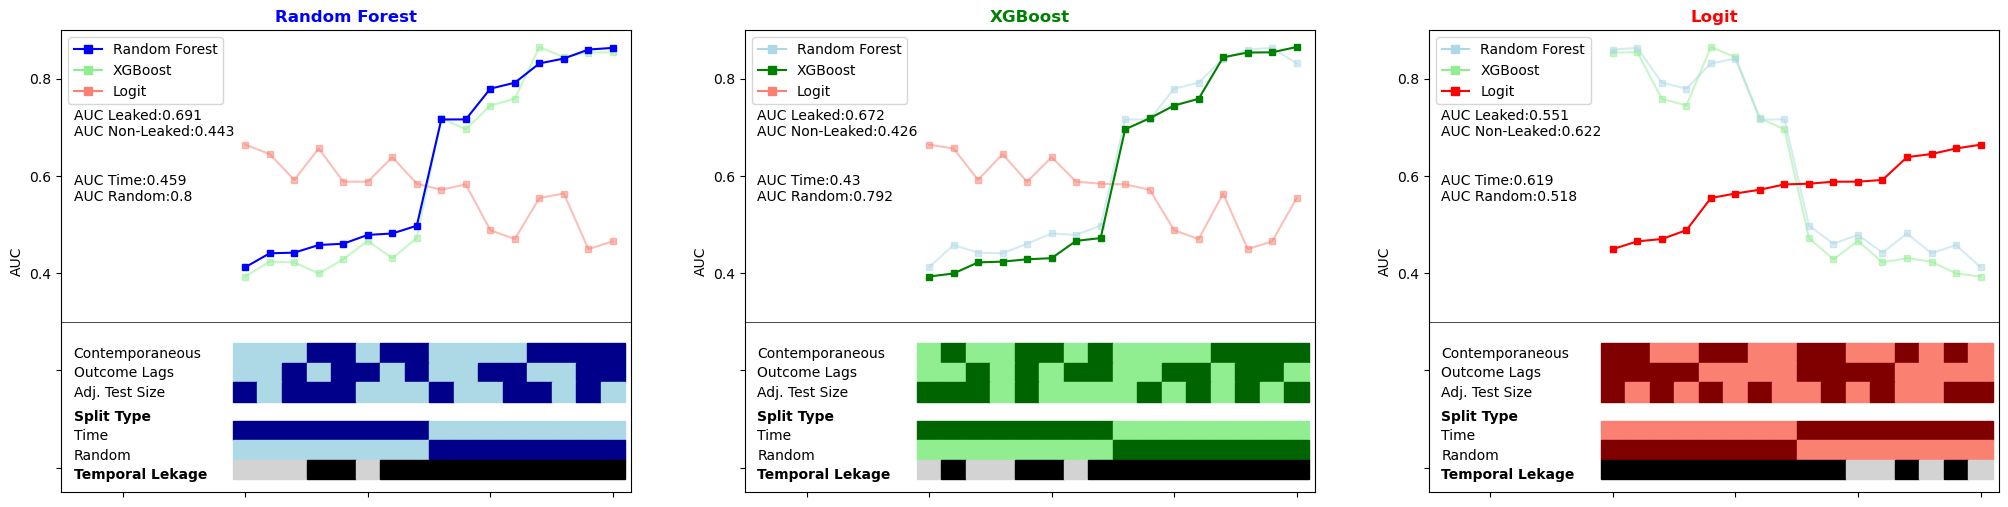

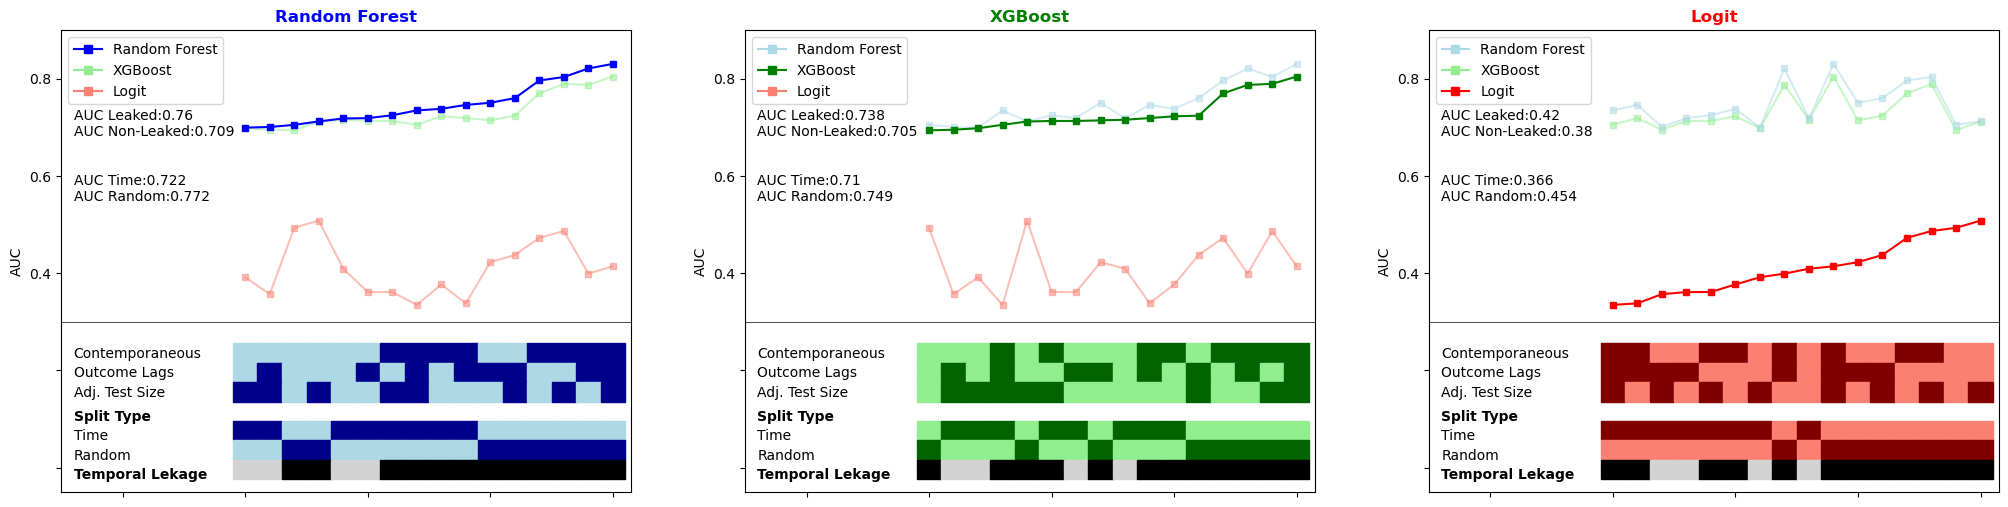

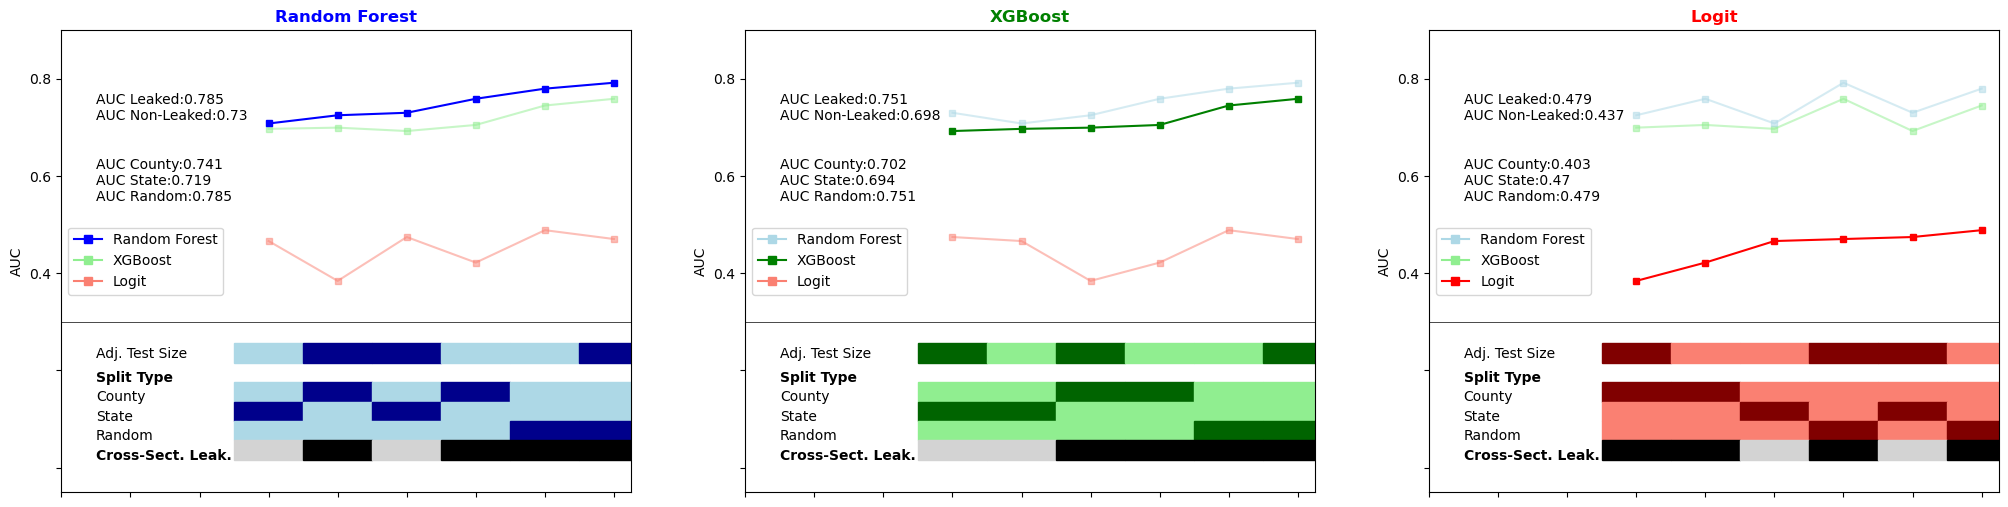

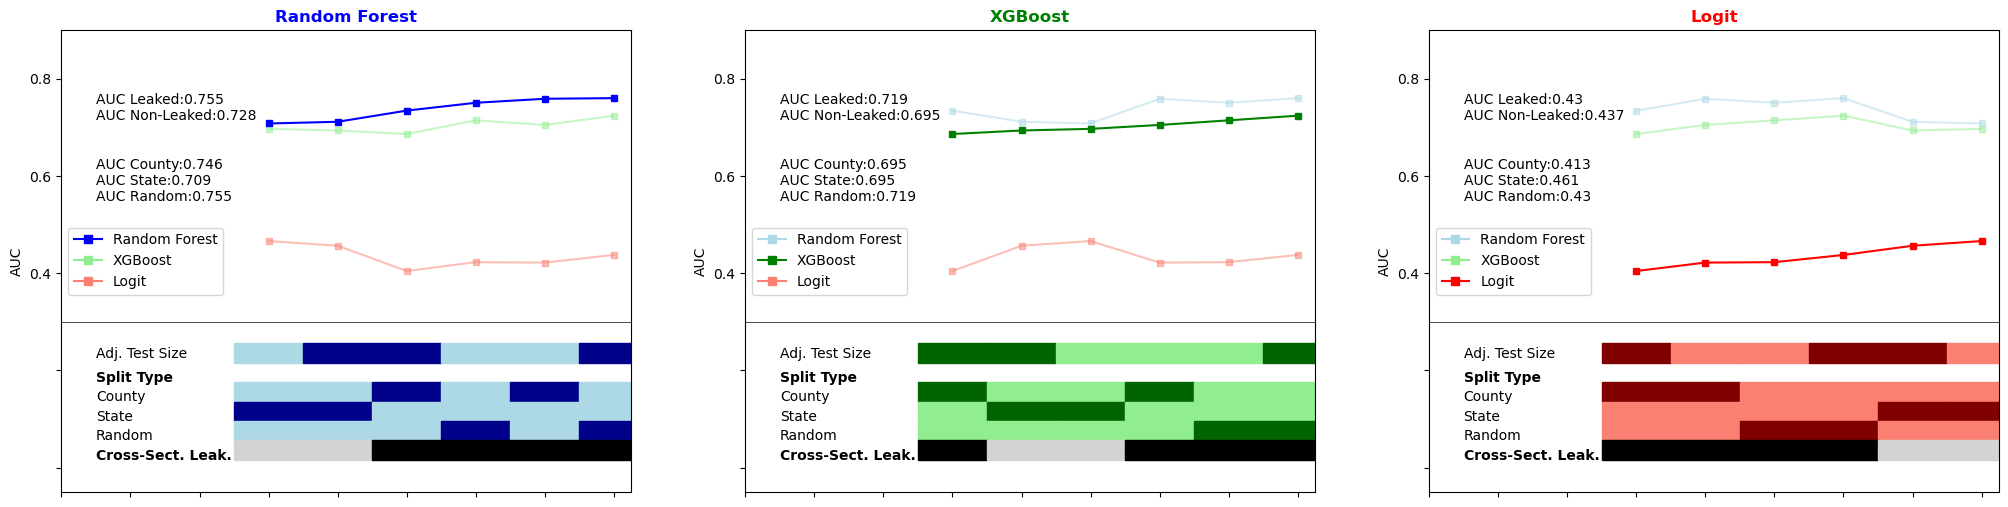

In [11]:
mode = "time"
perf_var = "auc"
for mode in ["time","space"]:
    for periodo in ["recession","all"]:
        fig,axss=plt.subplots(figsize=(25,6),ncols=3)

        for axs,model,c,cdark,clight in zip(axss,["rforest","xgboost","logit"],["blue","green","red"],["darkblue","darkgreen","maroon"],["lightblue","lightgreen","salmon"]):

            dplot = tab.loc[(tab["model"]==model)&(tab["period"]==periodo)].copy()
            dplot["recession"] = dplot["period"].apply(lambda x: "yes" if x=="recession" else "no")

            if mode=="space":
                dplot = dplot.loc[(dplot["include_lag_outcomes"]=="yes")&(dplot["include_contemporaneous"]=="no")&(dplot["split_type"].isin(['space', "space_states",'random']))]
            else:
                dplot = dplot.loc[(dplot["split_type"].isin(['random', "time"]))]

            dplot.reset_index(drop=True,inplace=True)
            dplot.reset_index(drop=False,inplace=True)

            for g in dplot["split_type"].unique():
                dplot[g] = dplot["split_type"].apply(lambda x:"yes" if x==g else "no")

            ## other models

            dplot2 = dplot.copy()
            dplot2["setting"] = dplot2[["period","include_contemporaneous","include_lag_outcomes","split_type","adjusted_size"]].apply(lambda x:"".join(list(x)),axis=1)
            dplot2.set_index("setting",inplace=True)
            tab2 = tab.copy()
            tab2["setting"] = tab2[["period","include_contemporaneous","include_lag_outcomes","split_type","adjusted_size"]].apply(lambda x:"".join(list(x)),axis=1)
            tab2.set_index("setting",inplace=True)
            altri_modelli = [x for x in ["logit","xgboost","rforest"] if x!=model]
            col_light = {"logit":"salmon","rforest":"lightblue","xgboost":"lightgreen"}
            for modello in altri_modelli:
                c_other = col_light[modello]
                altro_modello = tab2.loc[tab2["model"]==modello].loc[dplot2.index]
                altro_modello.reset_index(drop=True,inplace=True)
                altro_modello.reset_index().set_index("index")[perf_var].plot(ax=axs,color=c_other,marker="s",markersize=5,alpha=0.5)

                ## legend
            legend_elements = [
                plt.Line2D([0], [0], color='blue' if model=="rforest" else col_light["rforest"], marker='s', linestyle='-', label='Random Forest'),
                plt.Line2D([0], [0], color='green' if model=="xgboost" else col_light["xgboost"], marker='s', linestyle='-', label='XGBoost'),
                plt.Line2D([0], [0], color='red' if model=="logit" else col_light["logit"], marker='s', linestyle='-', label='Logit')
            ]

            dplot[perf_var].plot(ax=axs,color=c,marker="s",markersize=5)
            max_y = max([dplot[perf_var].max(),tab2[perf_var].max()])
            middlex = -0.5
            middley = max_y/4
            #middley = axs.get_ylim()[0]-0.05
            posx = 1 
            posy = 0
            
            spaziox = 2 if mode=="space" else 6.5
            height = 0.04
            axs.text(y=middley+posy+0.01+height,x=middlex-spaziox,s="",fontweight="bold")
            ## Recession
            lista_var = ["include_contemporaneous","include_lag_outcomes","adjusted_size"]
            if mode=="space":
                lista_var = ["adjusted_size"]
            for var in lista_var:
                axs.text(y=middley+posy+0.01,x=middlex-spaziox,s=dict_nomi[var])
                for i,row in dplot.iterrows():
                    axs.add_patch(Rectangle(color=cdark if row[var]=="yes" else clight,
                                            xy=(middlex+row["index"],middley+posy),
                                            width=1,
                                            height=height))
                posy = posy-height

            
            axs.text(y=middley+posy+0.001,x=middlex-spaziox,s="Split Type",fontweight="bold")
            posy = posy-height
            lista_var_sample = ['time', 'space_time','space', "space_states",'random',"time_leak","spatial_leak"]
            if mode=="space":
                lista_var_sample = ['space', "space_states",'random',"spatial_leak"]
            else:
                lista_var_sample = ["time","random","time_leak"]
            for var in lista_var_sample:
                axs.text(y=middley+posy+0.001,x=middlex-spaziox,s=dict_nomi[var],
                        fontweight = "bold" if var in ["time_leak","spatial_leak"] else "normal")
                for i,row in dplot.iterrows():
                    if mode=="space":
                        lista_leaks = ["spatial_leak"]
                    else:
                        lista_leaks = ["time_leak"]
                    if var not in lista_leaks:
                        axs.add_patch(Rectangle(color=cdark if row[var]=="yes" else (clight if row[var]=="no" else csuperlight),
                                                xy=(middlex+row["index"],middley+posy),
                                                width=1,
                                                height=height))
                    else:
                        axs.add_patch(Rectangle(color=leak_dict[row[var]],
                                xy=(middlex+row["index"],middley+posy),
                                width=1,
                                height=height))
                posy = posy-height

            if mode!="space":
                leaked = dplot.groupby("leaked")[perf_var].mean()["yes"].round(3)
                non_leaked = dplot.groupby("leaked")[perf_var].mean()["no"].round(3)
                leaked_ratio = np.round(leaked/non_leaked - 1,3)
                string_leakage = f'{perf_var.upper()} Leaked:{leaked}\n{perf_var.upper()} Non-Leaked:{non_leaked}\nLeakage ratio:{leaked_ratio} '

            
            if mode=="space":
                leaked_sp = dplot.groupby("leaked_sp")[perf_var].mean()["yes"].round(3)
                non_leaked_sp = dplot.groupby("leaked_sp")[perf_var].mean()["no"].round(3)
                leaked_ratio_sp = np.round(leaked_sp/non_leaked_sp - 1,3)
                string_leakage_sp = f'{perf_var.upper()} Leaked:{leaked_sp}\n{perf_var.upper()} Non-Leaked:{non_leaked_sp}\nLeakage ratio:{leaked_ratio_sp} '

            
            if mode=="space":
                main_result = string_leakage_sp.split("Leakage ratio")[0]
            else:
                main_result = string_leakage.split("Leakage ratio")[0]

            ris_by_group = pd.DataFrame(dplot.groupby("split_type")[perf_var].mean().loc[[x for x in lista_var_sample if "leak" not in x ]])
            stringa_samples = "\n\n"
            for i,row in ris_by_group.rename(dict_nomi).iterrows():
                stringa_samples+=f'{perf_var.upper()} {i}:{np.round(row[perf_var],3)}\n'
            axs.text(x=middlex-spaziox,y=max_y-0.35,s=main_result+stringa_samples)
            
            #axs.legend(handles=legend_elements,bbox_to_anchor=(0.7,0.5))
            axs.legend(handles=legend_elements,loc="upper left" if mode!="space" else "center left")
            axs.set_xlim(middlex-spaziox-0.5,axs.get_xlim()[1])
            axs.set_title(dict_nomi[model],fontweight="bold",color=c)
            axs.set_xticklabels("")
            axs.set_xlabel("")
            axs.set_ylabel(perf_var.upper())
            axs.set_ylim(-0.05,max_y*1.04)

            threshold = 0.3
            # newlabels = [label.set_text('') for label in axs.get_yticklabels() 
            #     if label.get_text().replace('−', '-') and float(label.get_text().replace('−', '-')) < threshold]
            # axs.set_ytick(newlabels)
            axs.set_yticklabels(labels=[x.get_text() if x.get_position()[1]>=threshold else "" for x in axs.get_yticklabels()])
            axs.axhline(y=threshold,color="black",linewidth=0.5)
            tab_to_export = tab2.loc[dplot2.index]
            tab_to_export.sort_values("auc").to_excel(f'{folder}tables\\results_classification_{periodo}_period_{mode}_{perf_var}.xlsx')
        #fig.suptitle(f"Models Performance {periodo} Observations",fontweight="bold",fontsize=18)
        fig.savefig(f'{folder}figures\\png\\results_classification_{periodo}_period_{mode}.png',bbox_inches="tight",dpi=600)
        fig.savefig(f'{folder}figures\\svg\\results_classification_{periodo}_period_{mode}.svg',bbox_inches="tight",dpi=300)


## Loop Models Regressors

the cell below takes ~ 573 minutes to run

In [12]:
## XGBOOST PARAMS
params = {
    'tree_method': 'approx',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',
    'random_state':random_seed,
#    'n_estimators':500
}


## RANDOM FOREST MODEL
regr = RandomForestRegressor(n_estimators=500,random_state=random_seed,max_depth=None,min_samples_split=10,min_samples_leaf=4)

## LINEAR REGRESSION MODEL
regr_linear = LinearRegression()

## LIST TO COLLECT RESULTS
period_list = []
include_contemp = []
split_type = []
adjusted_test = []
include_lag_outcomes = []
n_tests = []
model_list = []
mse_list = []
rsquared_list = []

advancement = 0
for period in ["recession","all"]:
    for include_contemporaneous in ["no","yes"]:
        for include_lag_outcome in ["no","yes"]:
            ## load split types
            sample_dict = create_sample(period=period,dep_var="log_income_pc")
            for sample_name in sample_dict.keys():
                X_train = sample_dict[sample_name]["train"]["x"]
                y_train = sample_dict[sample_name]["train"]["y"]
                X_test = sample_dict[sample_name]["test"]["x"]
                X_test_adj = sample_dict[sample_name]["test"]["x_adj"]
                y_test = sample_dict[sample_name]["test"]["y"]
                y_test_adj = sample_dict[sample_name]["test"]["y_adj"]

                if include_lag_outcome=="no":
                    ## if not including lagged dependent variables, drop it
                    for X_data in [X_train,X_test,X_test_adj]:
                        X_data.drop(lag_dependent,axis=1,inplace=True)

                if include_contemporaneous =="no":
                    ## if not including contemporaneous variable, keep only the lagged ones
                    for X_data in [X_train,X_test,X_test_adj]:
                        X_data.drop([x for x in X_data.columns if "lag" not in x],axis=1,inplace=True)
                else:
                    pass
                

                # RANDOM FOREST
                ## fit model
                regr.fit(X_train, y_train.values.flatten())
                ## make predictions
                y_predictions = regr.predict(X_test)
                ## compute results
                mse_list.append(root_mean_squared_error(y_true = y_test.values.flatten(),y_pred = y_predictions))

                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("no")
                model_list.append("rforest")

                # OLS MODEL
                ## fit model
                regr_linear.fit(X_train, y_train.values.flatten())
                ## make predictions
                y_predictions = regr_linear.predict(X_test)
                ## compute results
                mse_list.append(root_mean_squared_error(y_true = y_test.values.flatten(),y_pred = y_predictions))
                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("no")
                model_list.append("ols")

                ### XGB MODEL 
                ## fit the model
                dtrain = xgb.DMatrix(X_train, label=y_train.values.flatten())
                xgb_model = xgb.train(params, dtrain, num_boost_round=1000)

                ## make predictions
                dtest = xgb.DMatrix(X_test, label=y_test)
                y_predictions = xgb_model.predict(dtest)
                ## compute results
                mse_list.append(root_mean_squared_error(y_true = y_test.values.flatten(),y_pred = y_predictions))

                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("no")
                model_list.append("xgboost")


                # RANDOM FOREST NOT ADJUSTED
                ## make predictions
                y_predictions = regr.predict(X_test_adj)
                ## compute results
                mse_list.append(root_mean_squared_error(y_true = y_test_adj.values.flatten(),y_pred = y_predictions))

                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("yes")
                model_list.append("rforest")



                # OLS MODEL ADJUSTED
                ## make predictions
                y_predictions = regr_linear.predict(X_test_adj)
                ## compute results
                mse_list.append(root_mean_squared_error(y_true = y_test_adj.values.flatten(),y_pred = y_predictions))

                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("yes")
                model_list.append("ols")
 
                ## XGBOOST  ADJUSTED
                ## make predictions
                dtest = xgb.DMatrix(X_test_adj, label=y_test_adj)
                y_predictions = xgb_model.predict(dtest)
                ## compute results
                mse_list.append(root_mean_squared_error(y_true = y_test_adj.values.flatten(),y_pred = y_predictions))
                ## export results
                period_list.append(period)
                include_contemp.append(include_contemporaneous)
                split_type.append(sample_name)
                n_tests.append(y_test.shape[0])
                include_lag_outcomes.append(include_lag_outcome)
                adjusted_test.append("yes")
                model_list.append("xgboost")
                
                print(advancement)
                advancement+=1



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


## export results

In [14]:
df_result = pd.DataFrame({"period":period_list,"include_contemporaneous":include_contemp,
              "include_lag_outcomes":include_lag_outcomes,
              "split_type":split_type,"mse":mse_list,"adjusted_size":adjusted_test,"model":model_list}).sort_values("mse").reset_index(drop=True)
tab = pd.merge(df_result,df_sizes).sort_values("mse")
tab["leaked"] = ((tab["include_contemporaneous"]=="yes")|(~tab["split_type"].isin(["space_time","time"]))).replace({True:"yes",False:"no"})
tab.to_excel(f'{folder}\\regression_results.xlsx')

## Vizualizations Regressions

In [15]:
tab = pd.read_excel(f'{folder}\\regression_results.xlsx',index_col=0)
tab.sort_values("mse",ascending=False,inplace=True)
tab.reset_index(drop=True,inplace=True)
tab["leaked"] = ((tab["include_contemporaneous"]=="yes")|(~tab["split_type"].isin(["space_time","time"]))).replace({True:"yes",False:"no"})
tab["time_leak"] = tab[["include_contemporaneous","split_type"]].apply(lambda x:"high" if (x["include_contemporaneous"]=="yes")&(x["split_type"] not in ["space_time","time"]) else 
                                                    ("low" if (x["include_contemporaneous"]=="no")&(x["split_type"]  in ["space_time","time"]) else "medium") ,axis=1)

tab["spatial_leak"] = tab[["include_contemporaneous","split_type"]].apply(lambda x:"high" if "space" not in x["split_type"] else 
                                                    ("medium" if (x["split_type"] in ["space_time","space"]) else "low") ,axis=1)
tab["leaked"] = tab["time_leak"].replace({"high":"yes","low":"no","medium":"yes"})
tab["leaked_sp"] = tab["spatial_leak"].replace({"high":"yes","low":"no","medium":"no"})

space_leak = dict({'space_states':"low", 'time':"yes", 'random':"yes", 'space_time':"no", 'space':"no"})
leak_dict = {"low":"lightgrey","medium":"grey","high":"black"}
leak_dict = {"low":"lightgrey","medium":"black","high":"black"}
dict_nomi={'include_contemporaneous': 'Contemporaneous',
 'include_lag_outcomes': 'Outcome Lags',
 'recession': 'Recession',
 'adjusted_size': 'Adj. Test Size',
 'time': 'Time',
 'space_time': 'Space Time',
 'space_states': 'State',
 'space': 'County',
 'random': 'Random',
 'time_leak': 'Temporal Lekage',
 'spatial_leak': 'Cross-Sect. Leak.',"rforest":"Random Forest","xgboost":"XGBoost","logit":"Logit","ols":"Ols"}

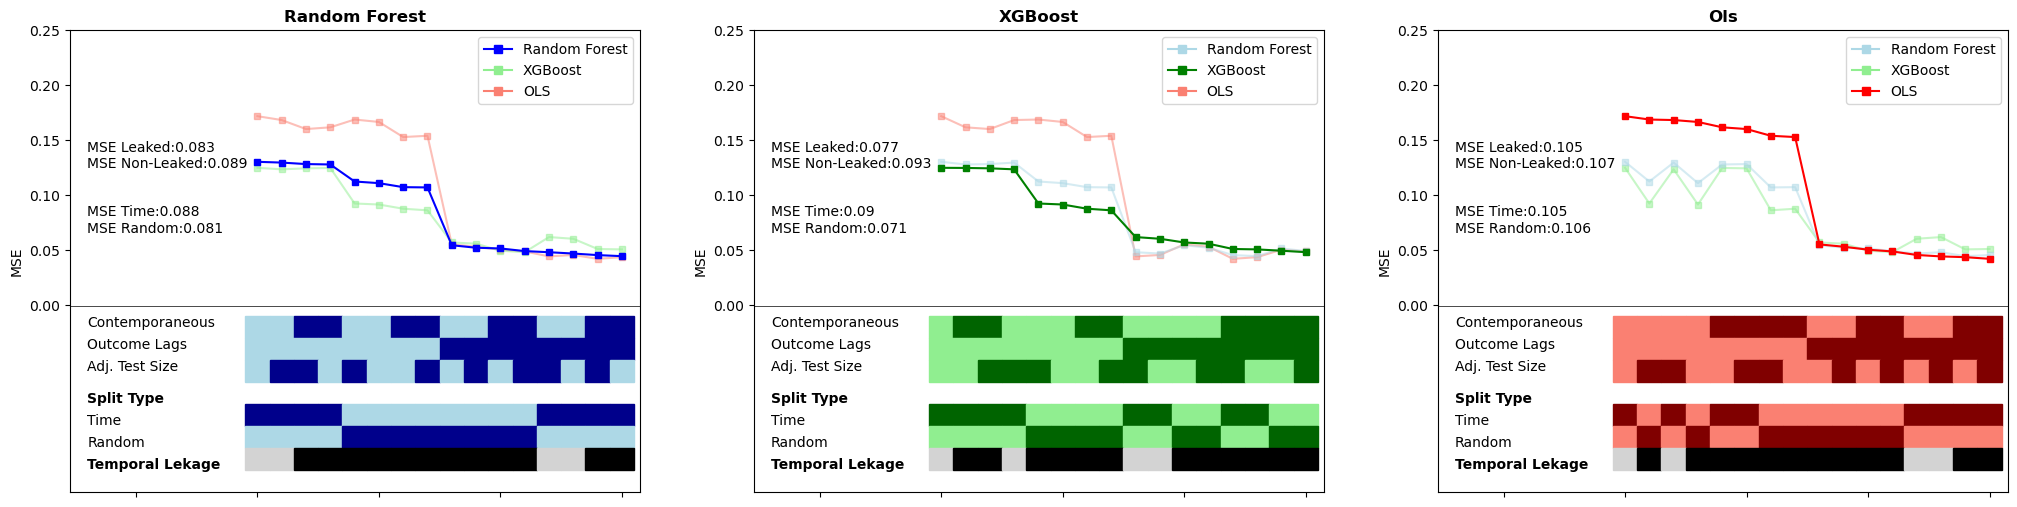

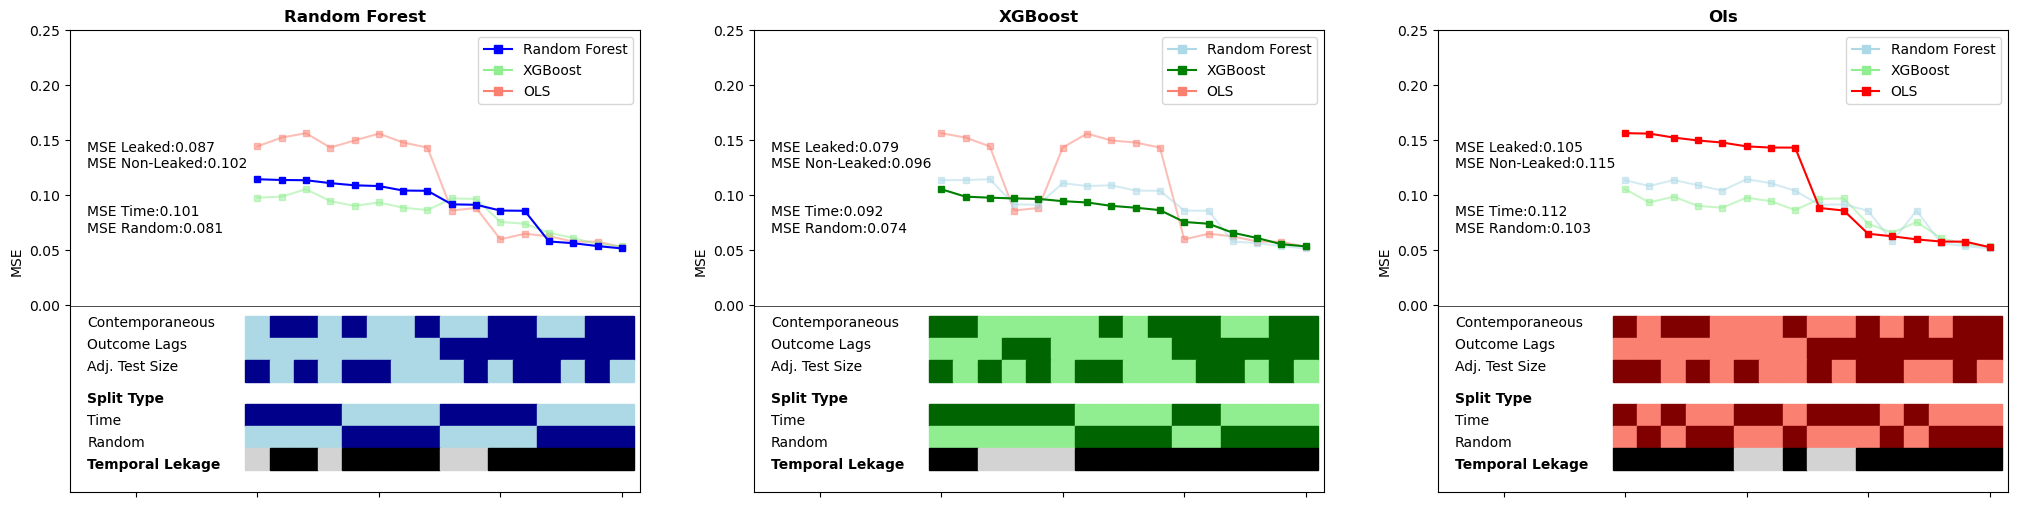

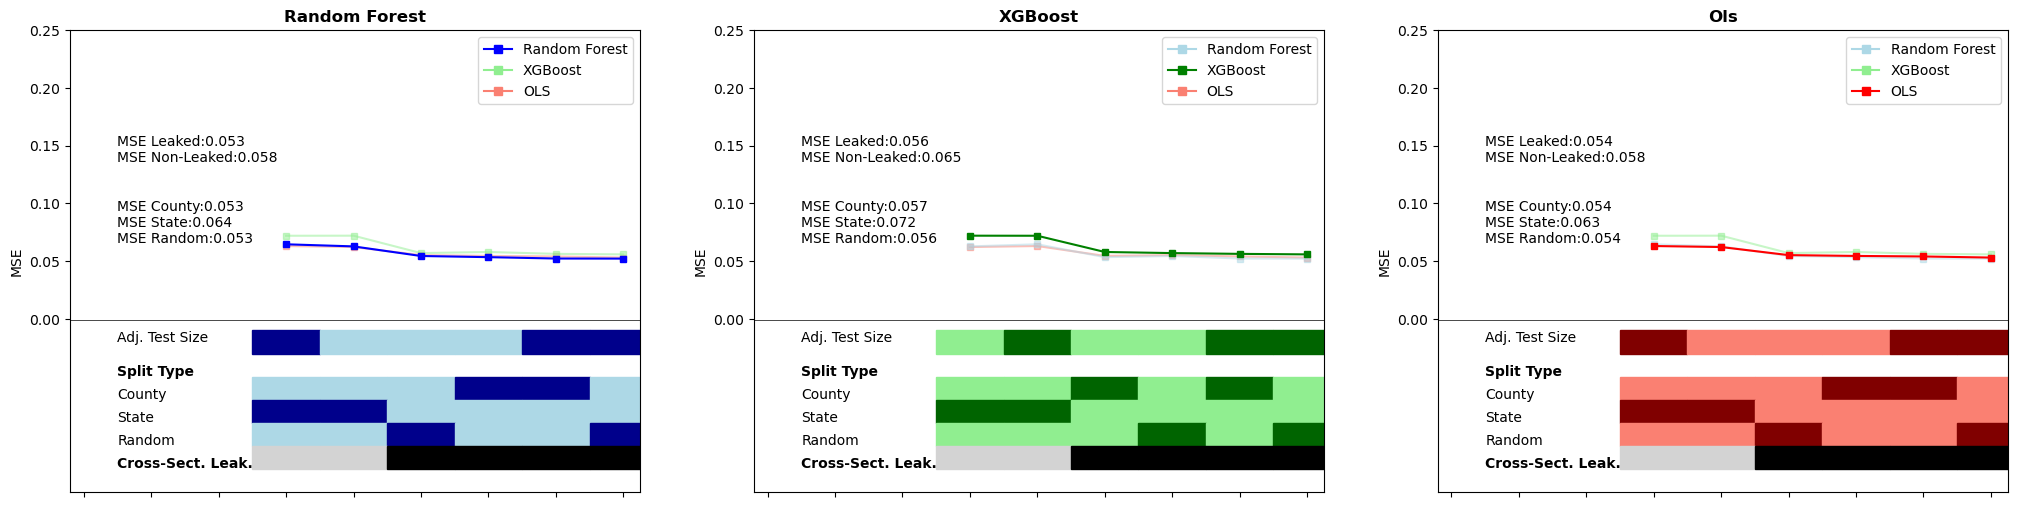

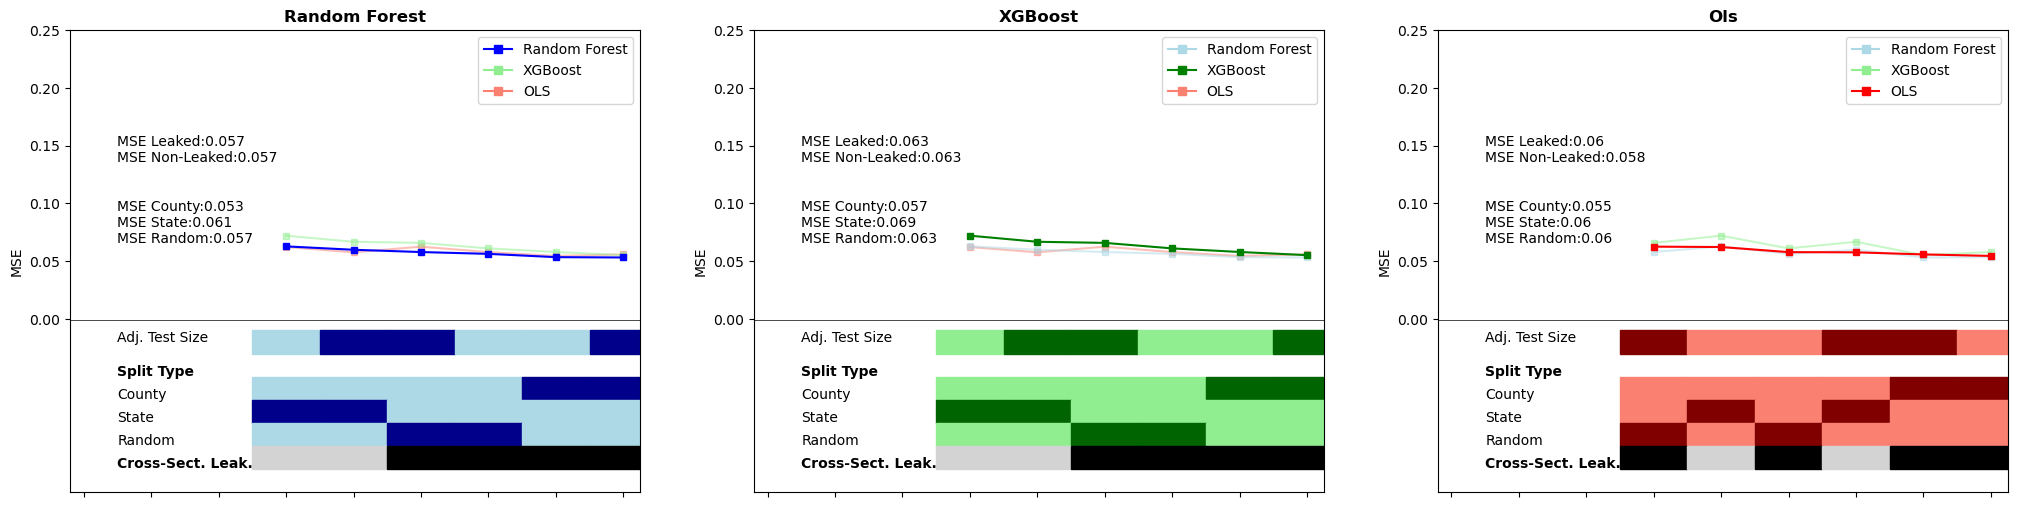

In [16]:
mode = "time"
perf_var = "mse"
linear_model = "logit" if perf_var=="auc" else "ols"
for mode in ["time","space"]:
    for periodo in ["all","recession"]:
        fig,axss=plt.subplots(figsize=(25,6),ncols=3)

        for axs,model,c,cdark,clight in zip(axss,["rforest","xgboost",linear_model],["blue","green","red"],["darkblue","darkgreen","maroon"],["lightblue","lightgreen","salmon"]):

            dplot = tab.loc[(tab["model"]==model)&(tab["period"]==periodo)].copy()
            dplot["recession"] = dplot["period"].apply(lambda x: "yes" if x=="recession" else "no")

            if mode=="space":
                dplot = dplot.loc[(dplot["include_lag_outcomes"]=="yes")&(dplot["include_contemporaneous"]=="no")&(dplot["split_type"].isin(['space', "space_states",'random']))]
            else:
                dplot = dplot.loc[(dplot["split_type"].isin(['random', "time"]))]

            dplot.reset_index(drop=True,inplace=True)
            dplot.reset_index(drop=False,inplace=True)

            for g in dplot["split_type"].unique():
                dplot[g] = dplot["split_type"].apply(lambda x:"yes" if x==g else "no")

            ## other models

            dplot2 = dplot.copy()
            dplot2["setting"] = dplot2[["period","include_contemporaneous","include_lag_outcomes","split_type","adjusted_size"]].apply(lambda x:"".join(list(x)),axis=1)
            dplot2.set_index("setting",inplace=True)
            tab2 = tab.copy()
            tab2["setting"] = tab2[["period","include_contemporaneous","include_lag_outcomes","split_type","adjusted_size"]].apply(lambda x:"".join(list(x)),axis=1)
            tab2.set_index("setting",inplace=True)
            altri_modelli = [x for x in ["logit" if perf_var=="auc" else "ols","xgboost","rforest"] if x!=model]
            col_light = {"logit" if perf_var=="auc" else "ols":"salmon","rforest":"lightblue","xgboost":"lightgreen"}
            for modello in altri_modelli:
                c_other = col_light[modello]
                altro_modello = tab2.loc[tab2["model"]==modello].loc[dplot2.index]
                altro_modello.reset_index(drop=True,inplace=True)
                altro_modello.reset_index().set_index("index")[perf_var].plot(ax=axs,color=c_other,marker="s",markersize=5,alpha=0.5)

                ## legend
            
            legend_elements = [
                plt.Line2D([0], [0], color='blue' if model=="rforest" else col_light["rforest"], marker='s', linestyle='-', label='Random Forest'),
                plt.Line2D([0], [0], color='green' if model=="xgboost" else col_light["xgboost"], marker='s', linestyle='-', label='XGBoost'),
                plt.Line2D([0], [0], color='red' if model==linear_model else col_light[linear_model], marker='s', linestyle='-', label=linear_model.upper())
            ]

            dplot[perf_var].plot(ax=axs,color=c,marker="s",markersize=5)
            max_y = max([dplot[perf_var].max(),tab2[perf_var].max()])
            middlex = -0.5
            #midy = max_y/4
            midy = 0 if mode=="time" else -0.03
            midy = -0.03 if mode=="time" else -0.03
            middley = midy 
            #middley = axs.get_ylim()[0]-0.05
            posx = 1 
            posy = 0
            
            spaziox = 2 if mode=="space" else 6.5
            height = 0.02
            axs.text(y=middley+posy+0.01+height,x=middlex-spaziox,s="",fontweight="bold")
            ## Recession
            lista_var = ["include_contemporaneous","include_lag_outcomes","adjusted_size"]
            if mode=="space":
                lista_var = ["adjusted_size"]
            for var in lista_var:
                axs.text(y=middley+posy+0.01,x=middlex-spaziox,s=dict_nomi[var])
                for i,row in dplot.iterrows():
                    axs.add_patch(Rectangle(color=cdark if row[var]=="yes" else clight,
                                            xy=(middlex+row["index"],middley+posy),
                                            width=1,
                                            height=height))
                posy = posy-height

            
            axs.text(y=middley+posy+0.001,x=middlex-spaziox,s="Split Type",fontweight="bold")
            posy = posy-height
            lista_var_sample = ['time', 'space_time','space', "space_states",'random',"time_leak","spatial_leak"]
            if mode=="space":
                lista_var_sample = ['space', "space_states",'random',"spatial_leak"]
            else:
                lista_var_sample = ["time","random","time_leak"]
            for var in lista_var_sample:
                axs.text(y=middley+posy+0.001,x=middlex-spaziox,s=dict_nomi[var],
                        fontweight = "bold" if var in ["time_leak","spatial_leak"] else "normal")
                for i,row in dplot.iterrows():
                    if mode=="space":
                        lista_leaks = ["spatial_leak"]
                    else:
                        lista_leaks = ["time_leak"]
                    if var not in lista_leaks:
                        axs.add_patch(Rectangle(color=cdark if row[var]=="yes" else (clight if row[var]=="no" else csuperlight),
                                                xy=(middlex+row["index"],middley+posy),
                                                width=1,
                                                height=height))
                    else:
                        axs.add_patch(Rectangle(color=leak_dict[row[var]],
                                xy=(middlex+row["index"],middley+posy),
                                width=1,
                                height=height))
                posy = posy-height

        #     main_result = f'''Average AUC Leaked models:{dplot.groupby("leaked")[perf_var].mean()["yes"].round(3)}\nAverage AUC Non-leaked models:{dplot.groupby("leaked")[perf_var].mean()["no"].round(3)}
        # Leakage Ratio:{((dplot.groupby("leaked")[perf_var].mean()["yes"]/dplot.groupby("leaked")[perf_var].mean()["no"]).round(3)-1).round(3)} 
        #                 '''
        #    main_result = f'Average AUC among:\nLeaked models:{dplot.groupby("leaked")[perf_var].mean()["yes"].round(2)}\nNon-leaked models:{dplot.groupby("leaked")[perf_var].mean()["no"].round(2)}'
            perf_var_name = perf_var.upper() if perf_var=="mse" else "R\u00b2"
            if mode!="space":
                leaked = dplot.groupby("leaked")[perf_var].mean()["yes"].round(3)
                non_leaked = dplot.groupby("leaked")[perf_var].mean()["no"].round(3)
                leaked_ratio = np.round(leaked/non_leaked - 1,3)
                string_leakage = f'{perf_var_name} Leaked:{leaked}\n{perf_var_name} Non-Leaked:{non_leaked}\nLeakage ratio:{leaked_ratio} '

            
            if mode=="space":
                leaked_sp = dplot.groupby("leaked_sp")[perf_var].mean()["yes"].round(3)
                non_leaked_sp = dplot.groupby("leaked_sp")[perf_var].mean()["no"].round(3)
                leaked_ratio_sp = np.round(leaked_sp/non_leaked_sp - 1,3)
                string_leakage_sp = f'{perf_var_name} Leaked:{leaked_sp}\n{perf_var_name} Non-Leaked:{non_leaked_sp}\nLeakage ratio:{leaked_ratio_sp} '

            
            #string_leakage_sp = f'Spatial Leakage:{leaked_ratio_sp} ({leaked_sp} / {non_leaked_sp})'
            if mode=="space":
                main_result = string_leakage_sp.split("Leakage ratio")[0]
            else:
                main_result = string_leakage.split("Leakage ratio")[0]

            ris_by_group = pd.DataFrame(dplot.groupby("split_type")[perf_var].mean().loc[[x for x in lista_var_sample if "leak" not in x ]])
            stringa_samples = "\n\n"
            for i,row in ris_by_group.rename(dict_nomi).iterrows():
                stringa_samples+=f'{perf_var.upper()} {i}:{np.round(row[perf_var],3)}\n'
            axs.text(x=middlex-spaziox,y=max_y-0.15,s=main_result+stringa_samples)
            
            #axs.legend(handles=legend_elements,bbox_to_anchor=(0.7,0.5))
            axs.legend(handles=legend_elements,loc="upper right")
            axs.set_xlim(middlex-spaziox-0.7,axs.get_xlim()[1])
            axs.set_ylabel(perf_var_name)
            axs.set_xlabel("")
            axs.set_xticklabels("")
            axs.set_title(dict_nomi[model],fontweight="bold")
            axs.set_ylim(-0.17 if mode=="time" else -0.15,max_y*1.04)

            # Get current tick positions
            ticks = axs.get_yticks()
            # Filter ticks to only keep those from 0 onward
            positive_ticks = [tick for tick in ticks if tick >= 0]
            axs.set_yticks(positive_ticks)

            threshold = -0.001
            # newlabels = [label.set_text('') for label in axs.get_yticklabels() 
            #     if label.get_text().replace('−', '-') and float(label.get_text().replace('−', '-')) < threshold]
            # axs.set_ytick(newlabels)
            axs.set_yticklabels(labels=[x.get_text() if x.get_position()[1]>=threshold else "" for x in axs.get_yticklabels()])
            axs.axhline(y=threshold,color="black",linewidth=0.5)

            # Set the filtered tick positions
            tab_to_export = tab2.loc[dplot2.index]
            tab_to_export.sort_values("mse").to_excel(f'{folder}tables\\results_regression_{periodo}_period_{mode}_logincome_{perf_var}.xlsx')
        
        #fig.suptitle(f"Models Performance {periodo} Observations",fontweight="bold",fontsize=18)
        fig.savefig(f'{folder}figures\\png\\results_regression_{periodo}_period_{mode}_logincome_{perf_var}.png',bbox_inches="tight",dpi=600)
        fig.savefig(f'{folder}figures\\svg\\results_regression_{periodo}_period_{mode}_logincome_{perf_var}.svg',bbox_inches="tight",dpi=300)


In [ ]:
print("done")

done


## Finish